# Numpy Implementation 

In [19]:
import numpy as np
import os
import json
import matplotlib.pyplot as plt
from util import get_wikipedia_data, find_analogies

In [20]:
class Glove(object):
    def __init__(self, D, V, context_sz):
        # word embedding dimension
        self.D = D
        self.V = V
        self.context_sz = context_sz

    def build_cc(self, sentences, cc_matrix=None):
        V = self.V
        D = self.D

        if not os.path.isfile(cc_matrix):
            X = np.zeros((V, V))
            N = len(sentences)
            it = 0

            for sentence in sentences:
                it += 1
                if it % 100 == 0:
                    print("processed: {} / {}".format(it, N))

                n = len(sentence)
                for i, wi in enumerate(sentence):
                    start = max(0, i-self.context_sz)
                    end = min(n, self.context_sz+i)

                    # we can either choose only one side as context, or both
                    # here we are doing both
                    # make sure "start" and "end" tokens are part of some context
                    # otherwise their f(X) will be 0 (denominator in bias update)
                    if i < self.context_sz:
                        # i's distance to 'start'
                        point = 1.0 / (1 + i)
                        X[wi, 0] += point
                        X[0, wi] += point

                    if i > n-self.context_sz:
                        # i's distance to 'end'
                        point = 1.0 / (n-i)
                        X[wi, 1] += point
                        X[1, wi] += point

                    # left side - distance between start and i
                    for j in range(start, i):
                        wj = sentence[j]
                        point = 1.0 / (i-j)
                        X[wi, wj] += point
                        X[wj, wi] += point

                    # right side - distance between i and end
                    for j in range(i+1, end):
                        wj = sentence[j]
                        point = 1.0 / (j-i)
                        X[wi, wj] += point
                        X[wj, wi] += point

            # save to local file
            np.savez(cc_matrix, X)
        else:
            X = np.load(cc_matrix)
            X = X.f.arr_0
        print("max in X:", X.max())
        return X

    def fit(self, sentences, cc_matrix, lr=1e-4, alpha=0.75, Xmax=100, epochs=1, reg=0.01, gradient_descent=False):
        # build co-occurrence matrix
        # paper calls it X, so we will call it X, instead of calling
        # the training data X
        X = self.build_cc(sentences, cc_matrix)
        V = self.V
        D = self.D

        # weighting
        # fX=(X/Xmax)^alpha if X<Xmax else 1
        fX = np.zeros((V, V))
        fX[X < Xmax] = (X[X < Xmax] / float(Xmax))**alpha
        fX[X >= Xmax] = 1
        print("max in fX:", fX.max())

        # target
        logX = np.log(X+1)
        print("max in log X:", logX.max())

        # initialize weights
        W = np.random.randn(V, D)/np.sqrt(V+D)
        U = np.random.randn(V, D)/np.sqrt(V+D)
        b = np.zeros(V)
        c = np.zeros(V)
        mu = logX.mean()

        costs = []
        for epoch in range(epochs):
            """
            J=\sum_i \sum_j f(X_{ij})(w_i^Tu_j-\log{X_{ij}})^2
            """
            # b is supposed to be a column vector and c is supposed to be a row vector.
            target_hat = W.dot(U.T)+b.reshape(V, 1)+c.reshape(1, V)+mu
            J = (fX*((target_hat-logX)**2)).sum()
            print("epoch:", epoch, "costs:", int(J))
            costs.append(J)

            if not gradient_descent:
                """ALS method"""
                # update W
                for i in range(V):
                    matrix = reg*np.eye(D) + (fX[i, :]*U.T).dot(U)
                    vector = (fX[i, :]*(logX[i, :]-b[i]-c-mu)).dot(U)
                    W[i] = np.linalg.solve(matrix, vector)

                # update b
                for i in range(V):
                    denominator = fX[i, :].sum()
                    numerator = fX[i, :].dot(logX[i, :]-W[i].dot(U.T)-c-mu)
                    b[i] = numerator / denominator/(reg+1)

                # update U
                for j in range(V):
                    matrix = reg*np.eye(D)+(fX[:, j]*W.T).dot(W)
                    vector = (fX[:, j]*(logX[:, j]-b-c[j]-mu)).dot(W)
                    U[j] = np.linalg.solve(matrix, vector)

                # update c
                for j in range(V):
                    denominator = fX[:, j].sum()
                    numerator = fX[:, j].dot(logX[:, j]-W.dot(U[j])-b-mu)
                    c[j] = numerator / denominator / (reg+1)
            else:
                """Gradient descent"""
                delta = target_hat-logX
                oldW = W.copy()

                # update W
                for i in range(V):
                    W[i] -= lr*(fX[i, :]*delta[i, :]).dot(U)
                W -= lr*reg*W

                # update b
                for i in range(V):
                    b[i] -= lr*fX[i, :].dot(delta[i, :])
                b -= lr*reg*b

                # update U
                for j in range(V):
                    U[j] -= lr*(fX[:, j]*delta[:, j]).dot(oldW)
                U -= lr*reg*U

                # update c
                for j in range(V):
                    c[j] -= lr*fX[:, j].dot(delta[:, j])
                c -= lr*reg*c

        self.W = W
        self.U = U

        plt.plot(costs)
        plt.show()

    def save(self, fn):
        arrays = [self.W, self.U.T]
        np.savez(fn, *arrays)

In [21]:
n_files = 100
we_file = "./model/glove_model_50.npz"
w2i_file = "./model/glove_word2idx_50.json"
# remember, only the co-occurrence matrix is needed for training
cc_matrix = "./model/cc_matrix_{}.npz".format(n_files)

In [22]:
# load word2idx
if os.path.isfile(cc_matrix):
    with open(w2i_file, 'r') as f:
        word2idx = json.load(f)
    sentences = []  # dummy - we won't actually use it

else:
    sentences, word2idx = get_wikipedia_data(n_files, n_vocab=2000)
    with open(w2i_file, 'w') as f:
        json.dump(word2idx, f)

V = len(word2idx)

max in X: 75446433.19258384
max in fX: 1.0
max in log X: 18.13893348152565
epoch: 0 costs: 5745302
epoch: 1 costs: 349579
epoch: 2 costs: 212141
epoch: 3 costs: 196484
epoch: 4 costs: 191421
epoch: 5 costs: 189132
epoch: 6 costs: 187896
epoch: 7 costs: 187149
epoch: 8 costs: 186661
epoch: 9 costs: 186320
epoch: 10 costs: 186072
epoch: 11 costs: 185885
epoch: 12 costs: 185739
epoch: 13 costs: 185624
epoch: 14 costs: 185531
epoch: 15 costs: 185454
epoch: 16 costs: 185391
epoch: 17 costs: 185338
epoch: 18 costs: 185293
epoch: 19 costs: 185254
epoch: 20 costs: 185221
epoch: 21 costs: 185193
epoch: 22 costs: 185168
epoch: 23 costs: 185146
epoch: 24 costs: 185126
epoch: 25 costs: 185109
epoch: 26 costs: 185094
epoch: 27 costs: 185080
epoch: 28 costs: 185068
epoch: 29 costs: 185057


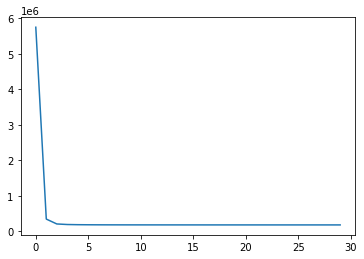

In [10]:
# train and save the GloVe model
gv = Glove(D=100, V=V, context_sz=10)

# ALS
gv.fit(sentences, cc_matrix=cc_matrix, lr=1e-4,
       reg=0.01, epochs=20, gradient_descent=False)

# GD
# gv.fit(
#     sentences,
#     cc_matrix=cc_matrix,
#     lr=5e-4,
#     reg=0.1,
#     epochs=500,
#     gradient_descent=True,
# )
gv.save(we_file)

In [11]:
# load back model
npz = np.load(we_file)
W1, W2 = npz['arr_0'], npz['arr_1']

idx2word = {v: k for k, v in word2idx.items()}

for We in ((W1+W2.T)/2, np.hstack([W1, W2.T])):
    print("*************************")
    find_analogies('king', 'man', 'woman', We, word2idx, idx2word)
    find_analogies('france', 'paris', 'london', We, word2idx, idx2word)
    find_analogies('france', 'paris', 'rome', We, word2idx, idx2word)
    find_analogies('paris', 'france', 'italy', We, word2idx, idx2word)
    find_analogies('france', 'french', 'english', We, word2idx, idx2word)
    find_analogies('japan', 'japanese', 'chinese', We, word2idx, idx2word)
    find_analogies('japan', 'japanese', 'italian', We, word2idx, idx2word)
    find_analogies('japan', 'japanese', 'australian', We, word2idx, idx2word)
    find_analogies('december', 'november', 'june', We, word2idx, idx2word)
    print()

*************************
closest match by euclidean distance: queen
king - man = queen - woman

closest match by cosine distance: queen
king - man = queen - woman

closest match by euclidean distance: england
france - paris = england - london

closest match by cosine distance: england
france - paris = england - london

closest match by euclidean distance: italy
france - paris = italy - rome

closest match by cosine distance: italy
france - paris = italy - rome

closest match by euclidean distance: berlin
paris - france = berlin - italy

closest match by cosine distance: rome
paris - france = rome - italy

closest match by euclidean distance: england
france - french = england - english

closest match by cosine distance: england
france - french = england - english

closest match by euclidean distance: china
japan - japanese = china - chinese

closest match by cosine distance: china
japan - japanese = china - chinese

closest match by euclidean distance: italy
japan - japanese = italy - 

# Tensorflow Implementation

In [4]:
import tensorflow as tf

In [11]:
class GloveTF(Glove):
    def __init__(self, D, V, context_sz):
        super().__init__(D, V, context_sz)
        pass

    def fit(self, sentences, cc_matrix, lr=1e-4, alpha=0.75, Xmax=100, epochs=1, reg=0.01, gradient_descent=False):
        # build co-occurrence matrix
        # paper calls it X, so we will call it X, instead of calling
        # the training data X
        X = self.build_cc(sentences, cc_matrix)
        V = self.V
        D = self.D

        # weighting
        # fX=(X/Xmax)^alpha if X<Xmax else 1
        fX = np.zeros((V, V))
        fX[X < Xmax] = (X[X < Xmax] / float(Xmax))**alpha
        fX[X >= Xmax] = 1
        print("max in fX:", fX.max())

        # target
        logX = np.log(X+1)
        print("max in log X:", logX.max())

        # initialize weights
        W = np.random.randn(V, D)/np.sqrt(V+D)
        U = np.random.randn(V, D)/np.sqrt(V+D)
        b = np.zeros(V)
        c = np.zeros(V)
        mu = logX.mean()

        # initialize weights, inputs, targets placeholders
        tfW = tf.Variable(W.astype(np.float32))
        tfU = tf.Variable(U.astype(np.float32))
        tfb = tf.Variable(b.reshape(V, 1).astype(np.float32))
        tfc = tf.Variable(c.reshape(1, V).astype(np.float32))
        

        plt.plot(costs)
        plt.show()

    def save(self, fn):
        arrays = [self.W, self.U.T]
        np.savez(fn, *arrays)

In [12]:
self = GloveTF(100, V, 10)

In [29]:
lr=1e-4 
alpha=0.75
Xmax=100
reg=0.01

X = self.build_cc(sentences, cc_matrix)
V = self.V
D = self.D

# weighting
# fX=(X/Xmax)^alpha if X<Xmax else 1
fX = np.zeros((V, V))
fX[X < Xmax] = (X[X < Xmax] / float(Xmax))**alpha
fX[X >= Xmax] = 1
print("max in fX:", fX.max())

# target
logX = np.log(X+1)
print("max in log X:", logX.max())

# initialize weights
W = np.random.randn(V, D)/np.sqrt(V+D)
U = np.random.randn(V, D)/np.sqrt(V+D)
b = np.zeros(V)
c = np.zeros(V)
mu = logX.mean()

# initialize weights, inputs, targets placeholders
tfW = tf.Variable(W.astype(np.float32))
tfU = tf.Variable(U.astype(np.float32))
tfb = tf.Variable(b.reshape(V, 1).astype(np.float32))
tfc = tf.Variable(c.reshape(1, V).astype(np.float32))
tfLog = tf.constant(logX,shape=(V,V),dtype=tf.float32)
tffX = tf.constant(fX,shape=(V,V),dtype=tf.float32)

delta = tf.matmul(tfW ,tf.transpose(a=tfU))+tfb+tfc+mu-tfLog
J=tf.math.reduce_sum(tffX*delta*delta) + reg*tf.math.reduce_sum(tfW**2)+ reg*tf.math.reduce_sum(tfU**2)


max in X: 75446433.19258384
max in fX: 1.0
max in log X: 18.13893348152565


AttributeError: module 'tensorflow' has no attribute 'compact'

In [25]:
delta.shape

TensorShape([2001, 2001])

In [24]:
np.random.rand(4,3)*np.ones((1,3))

array([[0.08009681, 0.31226675, 0.85673032],
       [0.90261428, 0.92750757, 0.43860123],
       [0.48060577, 0.46872246, 0.92006421],
       [0.07249769, 0.79180378, 0.48886042]])

In [28]:
J

<tf.Tensor: shape=(), dtype=float32, numpy=5745253.5>

# Visualize Countries 

In [4]:
from sklearn.manifold import TSNE

In [5]:
we_file='./model/glove_model_50.npz'
w2i_file='./model/glove_word2idx_50.json'

words = ['japan', 'japanese', 'england', 'english', 'australia', 'australian', 'china', 'chinese', 'italy', 'italian', 'french', 'france', 'spain', 'spanish']

In [11]:
with open(w2i_file, 'r') as f:
    word2idx = json.load(f)
npz = np.load(we_file)
idx = [word2idx[w] for w in words]

W1,W2=npz['arr_0'],npz['arr_1']

We=(W1+W2.T)/2
tnse = TSNE()
Z= tnse.fit_transform(We)
Z = Z[idx]

/usr/lib/python3/dist-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  This is separate from the ipykernel package so we can avoid doing imports until


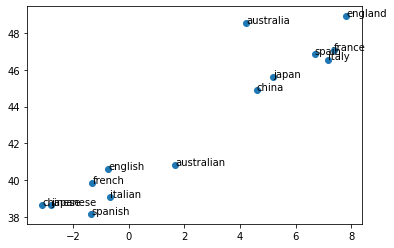

In [17]:
plt.scatter(Z[:,0],Z[:,1])
for i in range(len(words)):
    plt.annotate(s=words[i],xy=(Z[i,0],Z[i,1]))

# Training GloVe with SVD

In [32]:
from sklearn.decomposition import TruncatedSVD

In [42]:
class GloveSVD(Glove):
    def __init__(self,D,V,context_sz):
        super().__init__(D,V,context_sz)
        pass
    
    def fit(self,sentences,cc_matrix=None):
        X = self.build_cc(sentences, cc_matrix)
        V=self.V
        D=self.D
        
        # target
        logX=np.log(X+1)
        print("max in log(X):", logX.max())

        # subtract mean
        mu=np.mean(logX)

        model = TruncatedSVD(n_components=D)
        Z=model.fit_transform(logX-mu)

        S=np.diag(model.explained_variance_)
        S_inv = np.linalg.inv(S)

        self.W=Z.dot(S_inv)

        self.U=model.components_.T

        delta = self.W.dot(S).dot(self.U.T)+mu-logX
        cost=(delta**2).sum()
        print("svd cost:", cost)
        
    def save(self, fn):
        # function word_analogies expects a (V,D) matrx and a (D,V) matrix
        arrays = [self.W, self.U.T]
        np.savez(fn, *arrays)

In [43]:
n_files = 100
we_file = "./model/glove_model_50.npz"
w2i_file = "./model/glove_word2idx_50.json"
# remember, only the co-occurrence matrix is needed for training
cc_matrix = "./model/cc_matrix_{}.npz".format(n_files)

In [44]:
# load word2idx
if os.path.isfile(cc_matrix):
    with open(w2i_file, 'r') as f:
        word2idx = json.load(f)
    sentences = []  # dummy - we won't actually use it

else:
    sentences, word2idx = get_wikipedia_data(n_files, n_vocab=2000)
    with open(w2i_file, 'w') as f:
        json.dump(word2idx, f)

V = len(word2idx)

In [46]:
# train and save the GloVe model
gSVD = GloveSVD(D=100, V=V, context_sz=10)

# ALS
gSVD.fit(sentences, cc_matrix=cc_matrix)

gSVD.save(we_file)

max in X: 75446433.19258384
max in log(X): 18.13893348152565
svd cost: 857676.7831010601


In [47]:
# load back model
npz = np.load(we_file)
W1, W2 = npz['arr_0'], npz['arr_1']

idx2word = {v: k for k, v in word2idx.items()}

for We in ((W1+W2.T)/2, np.hstack([W1, W2.T])):
    print("*************************")
    find_analogies('king', 'man', 'woman', We, word2idx, idx2word)
    find_analogies('france', 'paris', 'london', We, word2idx, idx2word)
    find_analogies('france', 'paris', 'rome', We, word2idx, idx2word)
    find_analogies('paris', 'france', 'italy', We, word2idx, idx2word)
    find_analogies('france', 'french', 'english', We, word2idx, idx2word)
    find_analogies('japan', 'japanese', 'chinese', We, word2idx, idx2word)
    find_analogies('japan', 'japanese', 'italian', We, word2idx, idx2word)
    find_analogies('japan', 'japanese', 'australian', We, word2idx, idx2word)
    find_analogies('december', 'november', 'june', We, word2idx, idx2word)
    print()

*************************
closest match by euclidean distance: queen
king - man = queen - woman

closest match by cosine distance: queen
king - man = queen - woman

closest match by euclidean distance: britain
france - paris = britain - london

closest match by cosine distance: scotland
france - paris = scotland - london

closest match by euclidean distance: italy
france - paris = italy - rome

closest match by cosine distance: italy
france - paris = italy - rome

closest match by euclidean distance: rome
paris - france = rome - italy

closest match by cosine distance: rome
paris - france = rome - italy

closest match by euclidean distance: england
france - french = england - english

closest match by cosine distance: england
france - french = england - english

closest match by euclidean distance: china
japan - japanese = china - chinese

closest match by cosine distance: china
japan - japanese = china - chinese

closest match by euclidean distance: italy
japan - japanese = italy - it